In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import zipfile
from pathlib import Path

# Set the path to your zip file in Google Drive
zip_path = '/content/drive/MyDrive/ML4T/nasdaq100-1min.zip'

# Create a directory to store the data
data_dir = Path('/content/data')
data_dir.mkdir(exist_ok=True)

# Copy the zip file from Google Drive to Colab
!cp "{zip_path}" "{data_dir}/nasdaq100-1min.zip"

# Unzip the file
with zipfile.ZipFile(f"{data_dir}/nasdaq100-1min.zip", 'r') as zip_ref:
    zip_ref.extractall(data_dir)

# Remove the zip file to save space
os.remove(f"{data_dir}/nasdaq100-1min.zip")

print("Data has been successfully downloaded and extracted to /content/data")

# Update the nasdaq_path variable to point to the new location
nasdaq_path = Path('/content/data/nasdaq100')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data has been successfully downloaded and extracted to /content/data


In [2]:
# Working with Market Data: Processing Algoseek's Trade & Quote Minute Bar data

# This notebook demonstrates how to load and process high-quality NASDAQ100 minute-bar
# trade-and-quote data provided by Algoseek. This data will be used in Chapter 12
# to develop an intraday trading strategy.

## Imports & Settings

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for plots
sns.set_style('whitegrid')

# Create a shorthand for pandas' IndexSlice
idx = pd.IndexSlice

In [3]:
## Algoseek Trade & Quote Minute Bar Data

# The data dictionary and field descriptions are provided in the notebook.
# We'll focus on processing the data below.

## Data prep

# Define columns to drop (time-related columns and some others)
tcols = ['openbartime', 'firsttradetime', 'highbidtime', 'highasktime', 'hightradetime',
         'lowbidtime', 'lowasktime', 'lowtradetime', 'closebartime', 'lasttradetime']

drop_cols = ['unknowntickvolume', 'cancelsize', 'tradeatcrossorlocked']

# Define columns to keep
keep = ['firsttradeprice', 'hightradeprice', 'lowtradeprice', 'lasttradeprice',
        'minspread', 'maxspread', 'volumeweightprice', 'nbboquotecount',
        'tradeatbid', 'tradeatbidmid', 'tradeatmid', 'tradeatmidask', 'tradeatask',
        'volume', 'totaltrades', 'finravolume', 'finravolumeweightprice',
        'uptickvolume', 'downtickvolume', 'repeatuptickvolume', 'repeatdowntickvolume',
        'tradetomidvolweight', 'tradetomidvolweightrelative']

# Define a dictionary to rename columns (shortening most field names)
columns = {
    'volumeweightprice': 'price',
    'finravolume': 'fvolume',
    'finravolumeweightprice': 'fprice',
    'uptickvolume': 'up',
    'downtickvolume': 'down',
    'repeatuptickvolume': 'rup',
    'repeatdowntickvolume': 'rdown',
    'firsttradeprice': 'first',
    'hightradeprice': 'high',
    'lowtradeprice': 'low',
    'lasttradeprice': 'last',
    'nbboquotecount': 'nbbo',
    'totaltrades': 'ntrades',
    'openbidprice': 'obprice',
    'openbidsize': 'obsize',
    'openaskprice': 'oaprice',
    'openasksize': 'oasize',
    'highbidprice': 'hbprice',
    'highbidsize': 'hbsize',
    'highaskprice': 'haprice',
    'highasksize': 'hasize',
    'lowbidprice': 'lbprice',
    'lowbidsize': 'lbsize',
    'lowaskprice': 'laprice',
    'lowasksize': 'lasize',
    'closebidprice': 'cbprice',
    'closebidsize': 'cbsize',
    'closeaskprice': 'caprice',
    'closeasksize': 'casize',
    'firsttradesize': 'firstsize',
    'hightradesize': 'highsize',
    'lowtradesize': 'lowsize',
    'lasttradesize': 'lastsize',
    'tradetomidvolweight': 'volweight',
    'tradetomidvolweightrelative': 'volweightrel'
}

In [4]:
import os
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

nasdaq_path = Path('/content/data/nasdaq100')
drive_file_path = Path('/content/drive/MyDrive/ML4T/algoseek.h5')

def check_and_process_data():
    if drive_file_path.exists():
        print(f"algoseek.h5 found in Google Drive at {drive_file_path}")
        os.makedirs(nasdaq_path, exist_ok=True)
        local_file_path = nasdaq_path / 'algoseek.h5'
        print(f"Copying file to {local_file_path}")
        os.system(f"cp '{drive_file_path}' '{local_file_path}'")
    else:
        print("algoseek.h5 not found in Google Drive. Creating it from raw data.")
        extract_and_combine_data()

def extract_and_combine_data():
    print(f"nasdaq_path: {nasdaq_path}")

    data = []
    year_folders = [f for f in nasdaq_path.iterdir() if f.is_dir() and f.name.isdigit() and len(f.name) == 4]

    for year_folder in year_folders:
        date_folders = [f for f in year_folder.iterdir() if f.is_dir() and f.name.isdigit() and len(f.name) == 8]

        for date_folder in tqdm(date_folders, desc=f"Processing dates in {year_folder.name}", leave=False):
            file_list = list(date_folder.glob('*.csv.gz'))

            for f in file_list:
                df = (pd.read_csv(f, parse_dates=[['Date', 'TimeBarStart']])
                      .rename(columns=str.lower)
                      .drop(tcols + drop_cols, axis=1)
                      .rename(columns=columns)
                      .set_index('date_timebarstart')
                      .sort_index()
                      .between_time('9:30', '16:00')
                      .set_index('ticker', append=True)
                      .swaplevel()
                      .rename(columns=lambda x: x.replace('tradeat', 'at')))
                data.append(df)

    if not data:
        print("No data was processed. Check if the CSV files are in the correct location and format.")
        return

    data = pd.concat(data).apply(pd.to_numeric, downcast='integer')
    data.index.rename(['ticker', 'date_time'], inplace=True)
    print(data.info(show_counts=True))

    data.to_hdf(nasdaq_path / 'algoseek.h5', 'min_taq')
    print(f"Data saved to {nasdaq_path / 'algoseek.h5'}")

# Run the function
check_and_process_data()

# Load the combined data from the HDF5 file
df = pd.read_hdf(nasdaq_path / 'algoseek.h5', 'min_taq')

# Display information about the dataframe
df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
algoseek.h5 found in Google Drive at /content/drive/MyDrive/ML4T/algoseek.h5
Copying file to /content/data/nasdaq100/algoseek.h5
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31355463 entries, ('MNST', Timestamp('2017-12-14 09:30:00')) to ('ISRG', Timestamp('2015-12-01 16:00:00'))
Data columns (total 45 columns):
 #   Column         Dtype  
---  ------         -----  
 0   obprice        float64
 1   obsize         float64
 2   oaprice        float64
 3   oasize         float64
 4   first          float64
 5   firstsize      float64
 6   hbprice        float64
 7   hbsize         int32  
 8   haprice        float64
 9   hasize         int32  
 10  high           float64
 11  highsize       float64
 12  lbprice        float64
 13  lbsize         int32  
 14  laprice        float64
 15  lasize         int32  
 16  low            float64
 17  lowsize        

In [5]:
import os
import shutil
from google.colab import drive

def save_to_drive():
    # Mount Google Drive if not already mounted
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    # Source file path
    source_file = '/content/data/nasdaq100/algoseek.h5'

    # Destination path in Google Drive
    drive_path = '/content/drive/MyDrive/ML4T/algoseek.h5'

    # Create the ML4T folder if it doesn't exist
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)

    # Check if file already exists in Google Drive
    if os.path.exists(drive_path):
        print(f"File already exists in Google Drive: {drive_path}")
        replace = input("Do you want to replace it? (yes/no): ").lower()
        if replace != 'yes':
            print("File not replaced. Operation cancelled.")
            return

    # Copy the file to Google Drive
    shutil.copy(source_file, drive_path)
    print(f"File copied to Google Drive: {drive_path}")

# Run the function
save_to_drive()

File already exists in Google Drive: /content/drive/MyDrive/ML4T/algoseek.h5
Do you want to replace it? (yes/no): no
File not replaced. Operation cancelled.


Analyzing NASDAQ 100 Constituents
Number of unique stocks: 142

Top 10 most consistent stocks:
ticker
AAL     755
PCLN    755
GILD    755
FOXA    755
FOX     755
FISV    755
FB      755
FAST    755
PCAR    755
ESRX    755
dtype: int64

Bottom 10 least consistent stocks:
ticker
LILAK    119
EQIX      54
ALGN      48
BATRK     44
BATRA     44
CDNS       9
ASML       9
WDAY       9
SNPS       9
TTWO       9
dtype: int64


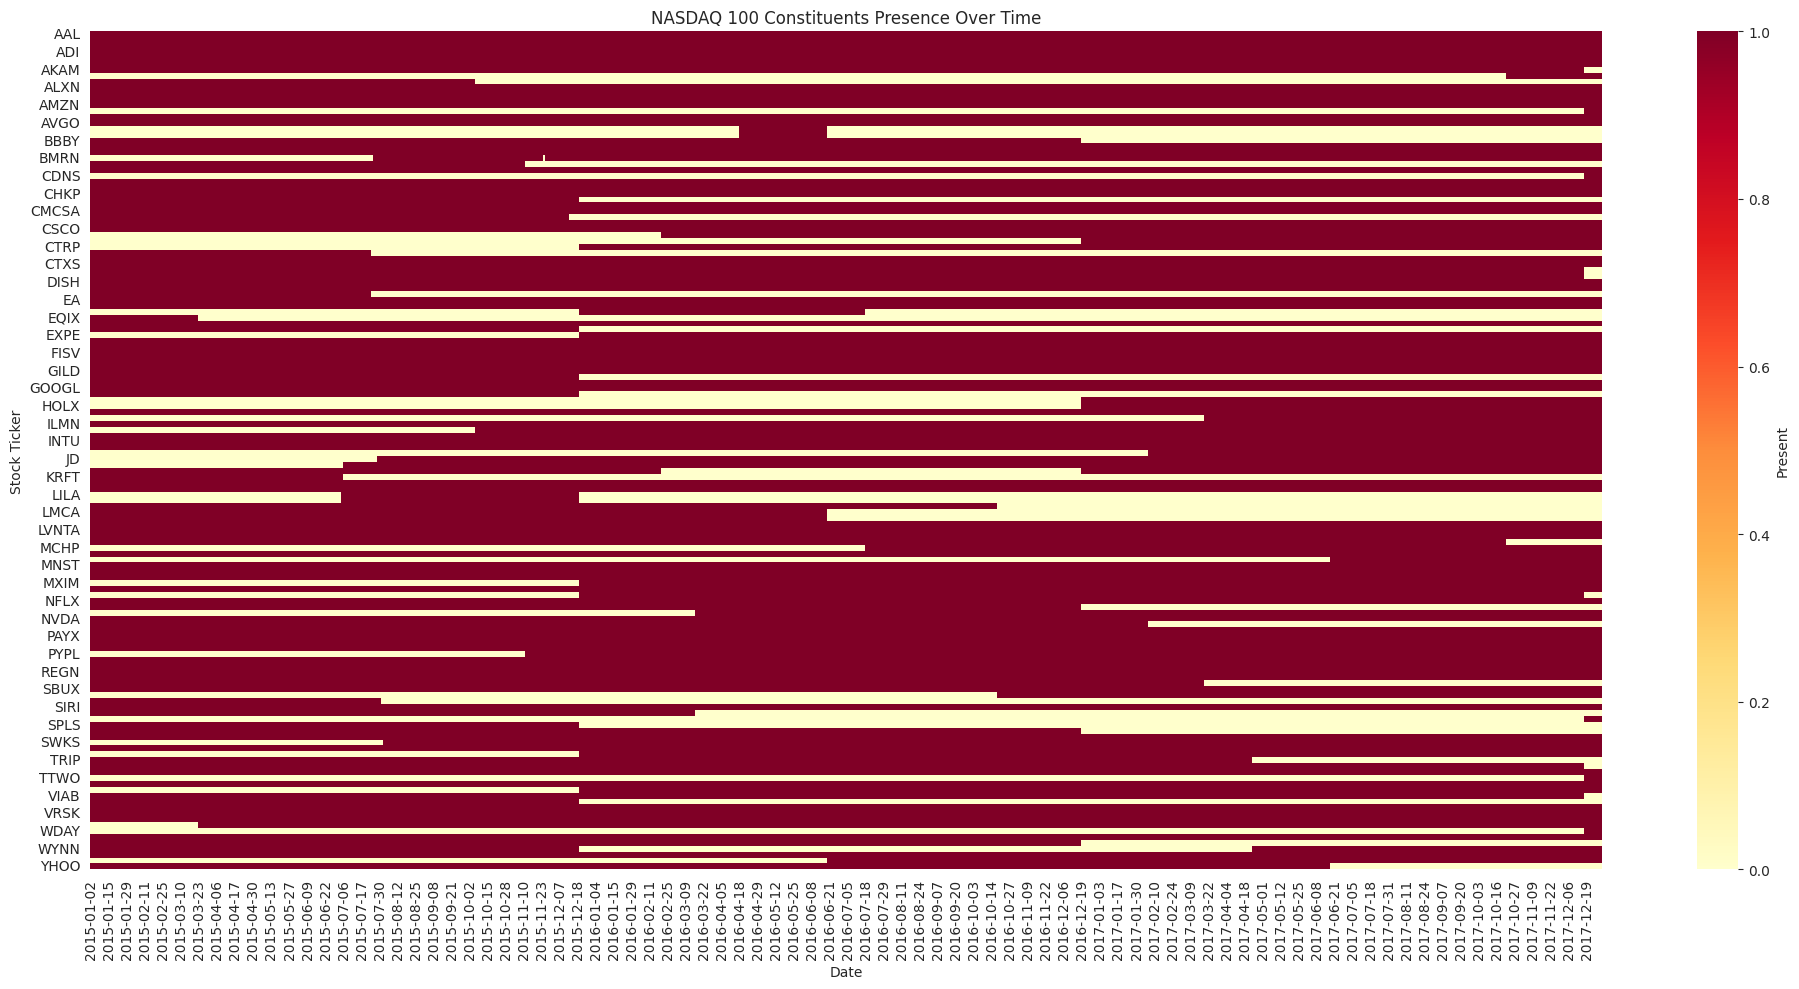


Stocks with most changes (entries/exits):
ticker
BMRN     3
LILA     2
BATRA    2
NCLH     2
WYNN     2
ENDP     2
KLAC     2
BATRK    2
LILAK    2
MXIM     1
dtype: object


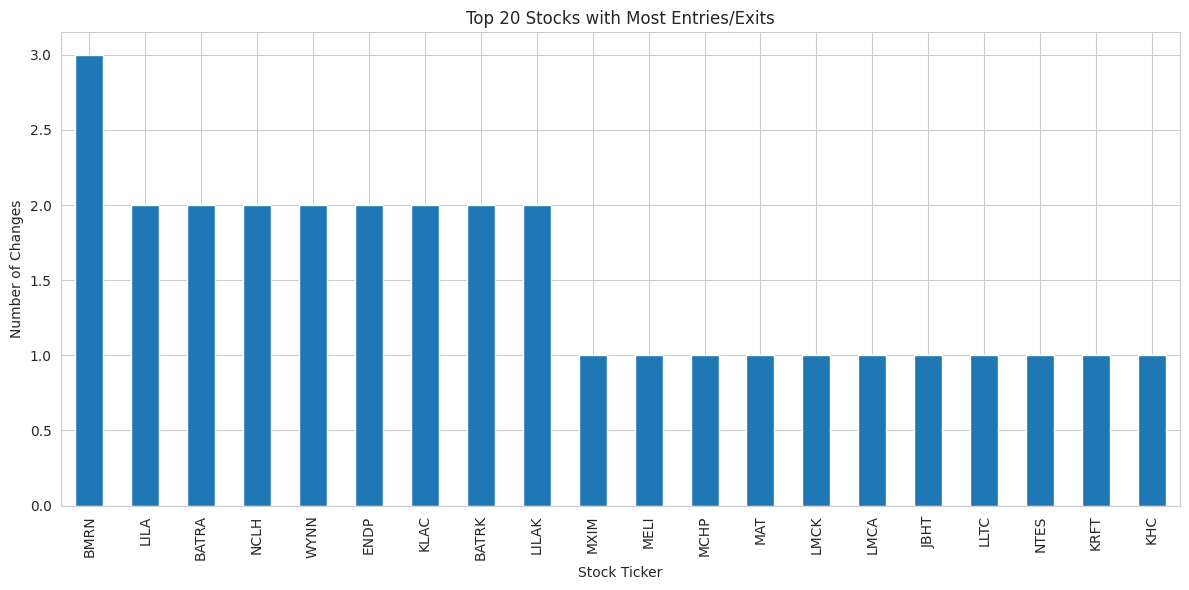


Top 10 stocks by total trading volume:
ticker
AAPL     16618496584
MSFT     14524003098
INTC     12258434550
SIRI     12241728979
MU       12008607008
CSCO     11651237302
FB        9367291549
CMCSA     7099112804
AMAT      6473644621
YHOO      5773678988
Name: volume, dtype: int64


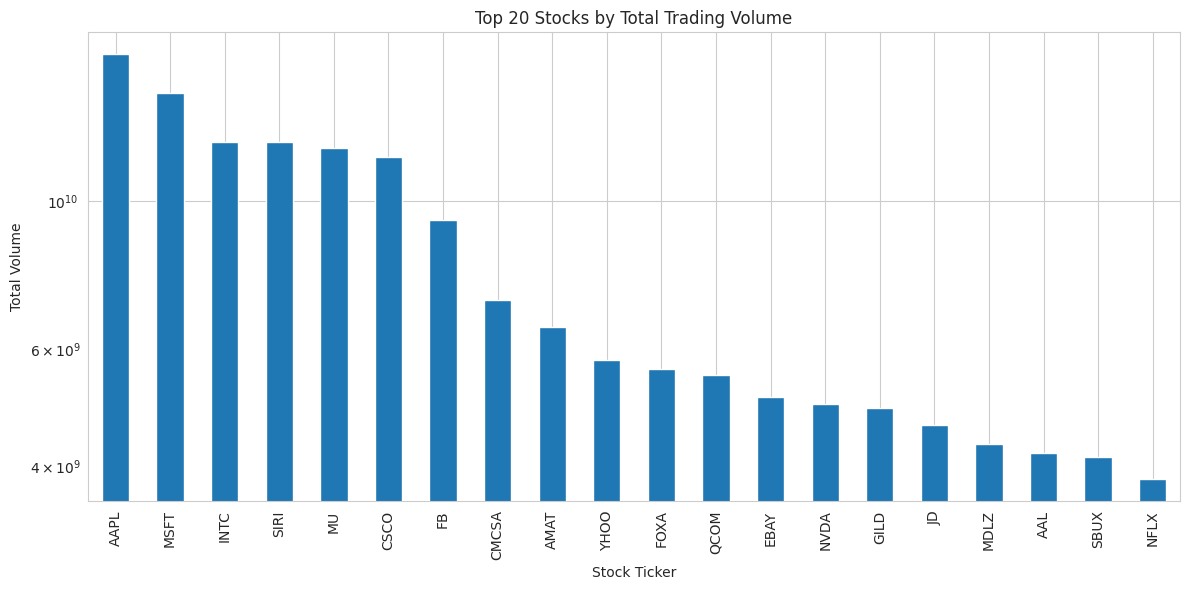


Top 10 stocks by average daily trading volume:
ticker
AAPL     2.201125e+07
MSFT     1.923709e+07
INTC     1.623634e+07
SIRI     1.621421e+07
MU       1.590544e+07
CSCO     1.543210e+07
FB       1.240701e+07
CMCSA    9.402798e+06
YHOO     9.327430e+06
AMAT     8.574364e+06
Name: volume, dtype: float64


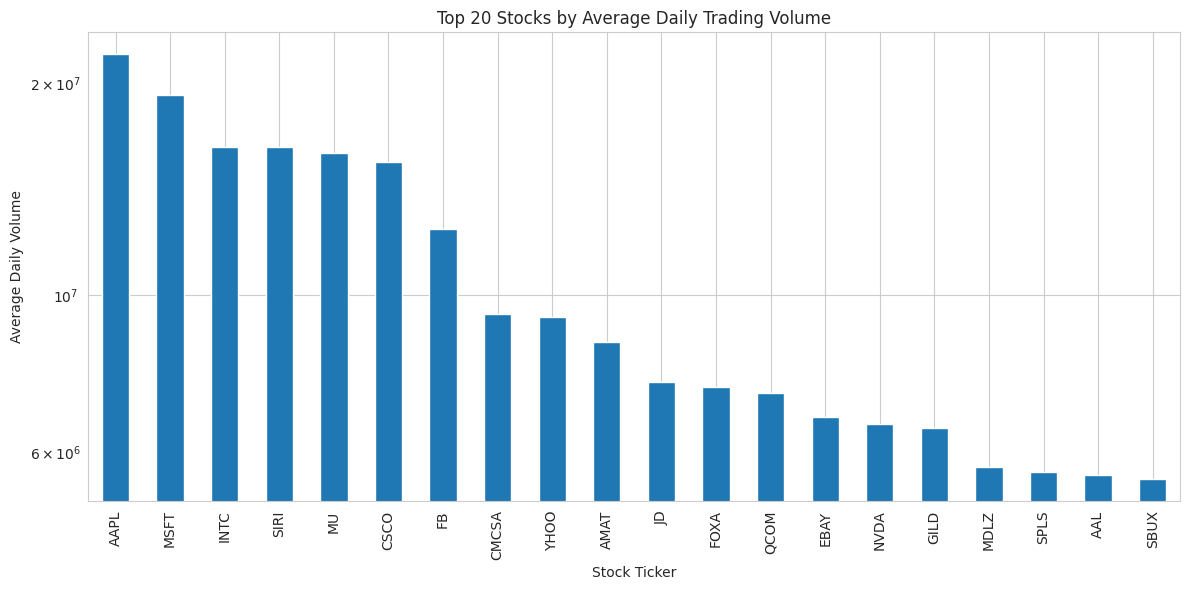


NASDAQ 100 Constituents Analysis Complete


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Assuming df is already loaded from the previous step
# If not, uncomment the following line:
# df = pd.read_hdf(Path('/content/data/nasdaq100/algoseek.h5'), 'min_taq')

# NASDAQ 100 Constituents Analysis

print("Analyzing NASDAQ 100 Constituents")

# Get unique tickers
unique_tickers = df.index.get_level_values('ticker').unique()
print(f"Number of unique stocks: {len(unique_tickers)}")

# Create a DataFrame to track daily presence of each stock
daily_presence = df.groupby([df.index.get_level_values('date_time').date, 'ticker']).size().unstack(fill_value=0).astype(bool)

# Calculate the number of days each stock was present
stock_presence = daily_presence.sum().sort_values(ascending=False)

print("\nTop 10 most consistent stocks:")
print(stock_presence.head(10))

print("\nBottom 10 least consistent stocks:")
print(stock_presence.tail(10))

# Visualize stock presence over time
plt.figure(figsize=(20, 10))
sns.heatmap(daily_presence.T, cmap='YlOrRd', cbar_kws={'label': 'Present'})
plt.title('NASDAQ 100 Constituents Presence Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Ticker')
plt.tight_layout()
plt.show()

# Analyze changes in constituents
constituent_changes = daily_presence.diff().sum().abs().sort_values(ascending=False)

print("\nStocks with most changes (entries/exits):")
print(constituent_changes.head(10))

# Visualize constituent changes
plt.figure(figsize=(12, 6))
constituent_changes.head(20).plot(kind='bar')
plt.title('Top 20 Stocks with Most Entries/Exits')
plt.xlabel('Stock Ticker')
plt.ylabel('Number of Changes')
plt.tight_layout()
plt.show()

# Analyze total trading volume
total_volume = df['volume'].groupby('ticker').sum().sort_values(ascending=False)

print("\nTop 10 stocks by total trading volume:")
print(total_volume.head(10))

# Visualize total trading volume
plt.figure(figsize=(12, 6))
total_volume.head(20).plot(kind='bar')
plt.title('Top 20 Stocks by Total Trading Volume')
plt.xlabel('Stock Ticker')
plt.ylabel('Total Volume')
plt.yscale('log')  # Using log scale for better visualization
plt.tight_layout()
plt.show()

# Analyze average daily trading volume
avg_daily_volume = df['volume'].groupby(['ticker', df.index.get_level_values('date_time').date]).sum().groupby('ticker').mean().sort_values(ascending=False)

print("\nTop 10 stocks by average daily trading volume:")
print(avg_daily_volume.head(10))

# Visualize average daily trading volume
plt.figure(figsize=(12, 6))
avg_daily_volume.head(20).plot(kind='bar')
plt.title('Top 20 Stocks by Average Daily Trading Volume')
plt.xlabel('Stock Ticker')
plt.ylabel('Average Daily Volume')
plt.yscale('log')  # Using log scale for better visualization
plt.tight_layout()
plt.show()

print("\nNASDAQ 100 Constituents Analysis Complete")

# NASDAQ 100 Constituents Analysis: Insights for Traders and Quants

## 1. Heatmap of Stock Presence Over Time

This heatmap provides a visual representation of when each stock was present in the NASDAQ 100 index.

**Insights:**
- Identify stable, long-term index components vs. more volatile entries/exits
- Spot periods of significant index composition changes
- Recognize potential structural breaks in the index that might affect long-term strategies
- Identify stocks that might be at risk of being removed from the index

## 2. Top 20 Stocks with Most Entries/Exits

This bar chart shows which stocks had the most frequent changes in their index membership.

**Insights:**
- Identify stocks with unstable index membership, which might be more volatile or risky
- Spot potential opportunities for trading around index rebalancing events
- Recognize stocks that might require more frequent portfolio adjustments in index-tracking strategies

## 3. Top 20 Stocks by Total Trading Volume

This bar chart displays the stocks with the highest cumulative trading volume over the entire period.

**Insights:**
- Identify the most liquid stocks in the index, which might be easier to trade in large quantities
- Spot potential candidates for high-frequency trading strategies
- Recognize stocks that might have lower transaction costs due to their high liquidity
- Identify stocks that might be more suitable for larger position sizes in a portfolio

## 4. Top 20 Stocks by Average Daily Trading Volume

This bar chart shows the stocks with the highest average daily trading volume.

**Insights:**
- Identify consistently liquid stocks, which might be more suitable for day trading or short-term strategies
- Recognize stocks that might be less prone to slippage in executions
- Spot potential candidates for market-making strategies
- Identify stocks that might be more resilient to sudden market movements due to their consistent liquidity

## General Observations:

- Differences between total volume and average daily volume rankings can reveal stocks with occasional high-volume events vs. those with consistent high liquidity
- Stocks with high trading volumes but frequent index entries/exits might represent interesting opportunities or risks
- Stable index components with high trading volumes might be good candidates for long-term positions or as hedging instruments
- Stocks with low presence in the index but high trading volumes when present might be worth investigating for the reasons behind their volatility

These insights can inform various aspects of trading and quantitative strategies, including risk management, portfolio construction, execution strategies, and alpha generation ideas.